In [1]:
import torch
import torch.nn.functional as F
import nibabel as nib
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader, random_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

c:\Users\rohit\.conda\envs\mini_project10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\rohit\.conda\envs\mini_project10\lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

C:\Users\rohit\AppData\Local\Temp\ipykernel_16392\3879156482.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path, map_locat

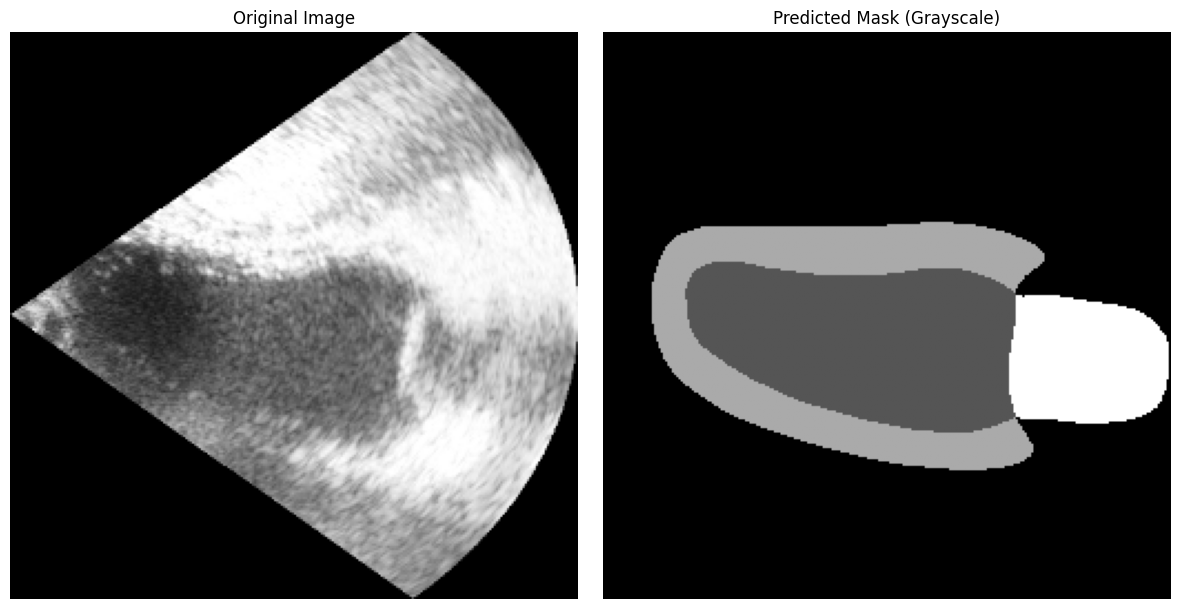

In [3]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import torch
import segmentation_models_pytorch as smp
import cv2  # For resizing and saving

# ----------------------------
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# Load the trained model
model_save_path = r"E:\PROJECTS\Mini_Project\sem_6\Combined\denseNet.pth"  # Update with your model path
model = smp.Unet(
    encoder_name="densenet121",
    encoder_weights="imagenet",
    in_channels=1,
    classes=4,        # Background + three foreground classes
    activation=None   # No activation (we'll apply sigmoid + argmax ourselves)
)
model.load_state_dict(torch.load(model_save_path, map_location=device))
model = model.to(device)
model.eval()

# ----------------------------
# Load the input .nii.gz file
input_file = r"E:\PROJECTS\Mini_Project\sem_6\nii_img\patient0001_2CH_ED.nii.gz"  # Update with your input file
nii_img = nib.load(input_file)
img_data = nii_img.get_fdata()

# Select a 2D slice if 3D
if img_data.ndim == 3:
    slice_index = img_data.shape[2] // 2
    img_slice = img_data[:, :, slice_index]
elif img_data.ndim == 2:
    img_slice = img_data
else:
    raise ValueError(f"Unexpected image dimensions: {img_data.shape}")

# Normalize to [0,1]
img_min, img_max = img_slice.min(), img_slice.max()
if img_max > img_min:
    img_slice = (img_slice - img_min) / (img_max - img_min)

# Resize to 256×256
img_resized = cv2.resize(img_slice.astype(np.float32), (256, 256))

# Prepare tensor: (B=1, C=1, H=256, W=256)
img_tensor = torch.from_numpy(img_resized).unsqueeze(0).unsqueeze(0).to(device)

# ----------------------------
# Run inference
with torch.no_grad():
    logits = model(img_tensor)               # (1, 4, 256, 256)
    probs  = torch.sigmoid(logits)           # (1, 4, 256, 256)
    pred_mask = torch.argmax(probs, dim=1)   # (1, 256, 256)
    pred_mask = pred_mask.squeeze(0).cpu().numpy().astype(np.uint8)

# ----------------------------
# Optional: save the raw mask as a single‐channel PNG
# Scale classes {0,1,2,3} → {0,85,170,255} for visibility
mask_to_save = (pred_mask * (255 // 3)).astype(np.uint8)
cv2.imwrite("pred_mask_gray.png", mask_to_save)

# ----------------------------
# Display side‐by‐side: original vs. predicted mask in grayscale
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Original image
axes[0].imshow(img_resized, cmap="gray")
axes[0].set_title("Original Image")
axes[0].axis("off")

# Predicted mask
axes[1].imshow(pred_mask, cmap="gray", vmin=0, vmax=3)
axes[1].set_title("Predicted Mask (Grayscale)")
axes[1].axis("off")

plt.tight_layout()
plt.savefig("segmentation_side_by_side_gray.png", bbox_inches="tight", pad_inches=0)
plt.show()


In [4]:
import torch
import torch.nn.functional as F

def lrp_0(layer, input_activation, relevance, epsilon=1e-6):
    """
    LRP-0 rule:
      R_j <- Σ_i ( z_ji / (Σ_j z_ji + ε) ) * R_i
    where z_ji = w_ji * a_j.
    """
    # Forward pass
    z = layer(input_activation)
    
    # Compute the "distribution" factor
    s = relevance / (z + epsilon)
    
    # Backprop relevance
    c = torch.autograd.grad(z, input_activation, s, retain_graph=True)[0]
    return input_activation * c


def lrp_epsilon(layer, input_activation, relevance, epsilon=1e-6):
    """
    LRP-ε rule (epsilon rule):
      R_j <- Σ_i ( z_ji + ε·sign(z_ji) ) / (Σ_j z_ji + ε·sign(Σ_j z_ji)) * R_i
    We implement a simplified version:
      1) Forward pass to get z
      2) Add small epsilon * sign(z) to stabilize
      3) Distribute relevance
      4) Gradient w.r.t. original z
    """
    z = layer(input_activation)
    
    # Add a sign-based stabilizer
    sign_z = torch.where(z >= 0, torch.ones_like(z), -torch.ones_like(z))
    z_eps = z + epsilon * sign_z
    
    # Distribute relevance
    s = relevance / z_eps
    # Use gradient w.r.t. z (not z_eps), so we pass `z` below:
    c = torch.autograd.grad(z, input_activation, s, retain_graph=True)[0]
    return input_activation * c


def lrp_z_plus(layer, input_activation, relevance, epsilon=1e-6):
    """
    z+ (ε) rule:
      Only the positive contributions are considered in z.
      R_j <- Σ_i ( z_ji^+ / (Σ_j z_ji^+ + ε) ) * R_i
    """
    # Forward pass
    z = layer(input_activation)
    
    # Keep only positive contributions
    z_plus = torch.clamp(z, min=0)
    
    # Distribute relevance based on z+ only
    s = relevance / (z_plus + epsilon)
    
    # We take gradient wrt z_plus to zero-out negative paths
    c = torch.autograd.grad(z_plus, input_activation, s, retain_graph=True)[0]
    
    # Multiply by positive part of input as well (common variant)
    return torch.clamp(input_activation, min=0) * torch.clamp(c, min=0)


def lrp_gamma(layer, input_activation, relevance, gamma=0.5, epsilon=1e-6):
    """
    LRP-γ rule:
      Scales positive weights by (1+γ) to boost positive contributions.
    """
    # Temporarily modify layer weights for the forward pass
    W_original = layer.weight.data
    with torch.no_grad():
        W_modified = W_original.clone()
        # Scale only positive weights by (1 + gamma)
        W_modified[W_modified > 0] = W_modified[W_modified > 0] * (1.0 + gamma)
        layer.weight.data = W_modified
    
    # Forward pass with scaled weights
    z_mod = layer(input_activation)
    z_mod_plus = torch.clamp(z_mod, min=0)
    
    # Restore original weights
    layer.weight.data = W_original
    
    # Distribute relevance
    s = relevance / (z_mod_plus + epsilon)
    c = torch.autograd.grad(z_mod_plus, input_activation, s, retain_graph=True)[0]
    
    return torch.clamp(input_activation, min=0) * torch.clamp(c, min=0)


def lrp_alpha_beta(layer, input_activation, relevance, alpha=0.9, beta=0.1, epsilon=1e-6):
    z = layer(input_activation)
    
    z_pos = torch.clamp(z, min=0)
    z_neg = torch.clamp(z, max=0)

    # Scale relevance over positive and negative parts separately
    s_pos = relevance / (z_pos + epsilon)
    s_neg = relevance / (z_neg - epsilon)  # negative + ε → subtract for stability

    grad_pos = torch.autograd.grad(z, input_activation, s_pos, retain_graph=True, allow_unused=True)[0]
    grad_neg = torch.autograd.grad(z, input_activation, s_neg, retain_graph=True, allow_unused=True)[0]

    grad_pos = grad_pos if grad_pos is not None else torch.zeros_like(input_activation)
    grad_neg = grad_neg if grad_neg is not None else torch.zeros_like(input_activation)

    Rp = torch.clamp(input_activation, min=0) * torch.clamp(grad_pos, min=0)
    Rn = torch.clamp(input_activation, max=0) * torch.clamp(grad_neg, max=0)

    return alpha * Rp - beta * Rn



def lrp_flat(layer, input_activation, relevance, seg_mask=None):
    """
    Flat rule + optional masking.
    """
    # 1. Forward pass (ignored, just for shape consistency).
    z = layer(input_activation)
    
    # 2. Compute total relevance (sum over output).
    B, outC, outH, outW = z.shape
    B, inC, H, W = input_activation.shape
    total_relevance = relevance.view(B, -1).sum(dim=1, keepdim=True)  # [B,1]
    
    # 3. Distribute uniformly across all input pixels.
    num_input_elements = inC * H * W
    flat_relevance = total_relevance / float(num_input_elements)
    flat_relevance = flat_relevance.view(B, 1, 1, 1).expand(B, inC, H, W)

    # 4. Optional: multiply by segmentation mask to blank out background
    if seg_mask is not None:
        # seg_mask should have shape [B, 1, H, W] or [B, inC, H, W].
        # If needed, broadcast seg_mask to match [B, inC, H, W].
        if seg_mask.shape[1] == 1 and inC > 1:
            seg_mask = seg_mask.expand(-1, inC, -1, -1)
        flat_relevance = flat_relevance * seg_mask
    
    return flat_relevance



def lrp_w_squared(layer, input_activation, relevance, epsilon=1e-6):
    """
    w² rule:
      Relevance is distributed proportionally to w².
    """
    W_original = layer.weight.data
    with torch.no_grad():
        W_modified = (W_original**2).clone()
        layer.weight.data = W_modified
    
    z_w2 = layer(input_activation)
    
    # Restore original weights
    layer.weight.data = W_original
    
    # Distribute relevance
    s = relevance / (z_w2 + epsilon)
    c = torch.autograd.grad(z_w2, input_activation, s, retain_graph=True)[0]
    
    return input_activation * c


def lrp_zB(layer, input_activation, relevance, l=0.0, h=1.0, epsilon=1e-6):
    """
    z^B rule (bounded rule).
    """
    z = layer(input_activation)
    
    W = layer.weight
    W_plus = torch.clamp(W, min=0)
    W_minus = torch.clamp(W, max=0)
    
    x_plus = torch.clamp(input_activation, min=0)
    x_minus = torch.clamp(input_activation, max=0)
    
    # zB = z - l·(x^+ * w^+) - h·(x^- * w^-)
    z_b = z
    z_b = z_b - l * F.conv2d(x_plus, W_plus, bias=None,
                             stride=layer.stride, padding=layer.padding)
    z_b = z_b - h * F.conv2d(x_minus, W_minus, bias=None,
                             stride=layer.stride, padding=layer.padding)
    
    s = relevance / (z_b + epsilon)
    c = torch.autograd.grad(z, input_activation, s, retain_graph=True)[0]
    
    return input_activation * c


In [5]:
# Suppose this is code3.py

lrp_0, lrp_epsilon, lrp_z_plus, lrp_gamma,
lrp_alpha_beta, lrp_flat, lrp_w_squared, lrp_zB

lrp_functions = {
    "LRP-0": lrp_0,
    "epsilon": lrp_epsilon,     # <-- Added here
    "z-plus": lrp_z_plus,
    "gamma": lrp_gamma,
    "alpha-beta": lrp_alpha_beta,
    "flat": lrp_flat,
    "w-squared": lrp_w_squared,
    "zB": lrp_zB
}


In [6]:
import numpy as np
import matplotlib.pyplot as plt

def overlay_seg_mask_on_image(image_np, mask_np, alpha=0.5, mask_color=(1, 0, 0)):
    """
    Overlays a binary mask on top of the original image.
      image_np: [H, W, 3], float in [0,1]
      mask_np:  [H, W], float (0 or 1) or something that can be thresholded
      alpha:    blending factor
      mask_color: (R, G, B) in [0,1]
    """
    # Ensure mask is binary or in [0,1]
    mask_bin = (mask_np > 0.5).astype(np.float32)
    
    # Convert mask to 3D color
    mask_3d = np.stack([mask_bin * c for c in mask_color], axis=-1)  # [H, W, 3]
    
    # Blend
    out = (1 - alpha) * image_np + alpha * mask_3d
    return np.clip(out, 0, 1)


def overlay_heatmap_on_image(image_np, heatmap_np, alpha=0.5, cmap='jet'):
    """
    Overlays a continuous heatmap (0..1) on top of the original image.
      image_np:   [H, W, 3], float in [0,1]
      heatmap_np: [H, W], float in [0,1]
      alpha:      blending factor
      cmap:       a matplotlib colormap name
    """
    cm = plt.get_cmap(cmap)
    colored_hm = cm(heatmap_np)[:, :, :3]  # RGBA -> take only RGB
    
    # Blend
    out = (1 - alpha) * image_np + alpha * colored_hm
    return np.clip(out, 0, 1)


In [7]:
def lrp_class_specific(relevance, class_idx):
    """
    Extract the relevance for a specific class.
    Assumes relevance shape is (B, channels, H, W) and returns (B, 1, H, W).
    """
    class_relevance = relevance[:, class_idx, :, :]
    return class_relevance.unsqueeze(1)



def apply_segmentation_mask(relevance, segmentation_output, threshold=0.5):
    """
    Apply a binary mask to the relevance.
    segmentation_output is assumed to be a probability map.
    """
    mask = segmentation_output > threshold
    return relevance * mask

C:\Users\rohit\AppData\Local\Temp\ipykernel_16392\807004779.py:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=to

Segmentation output stats: min = 5.700348637560637e-09 max = 0.9999995231628418 mean = 0.2501225471496582


c:\Users\rohit\.conda\envs\mini_project10\lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


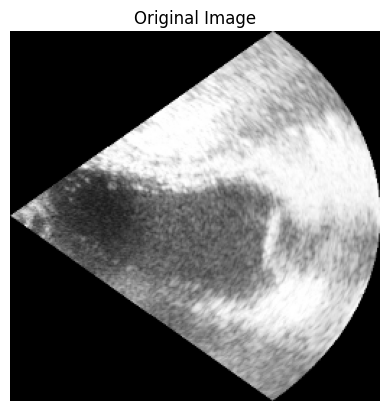

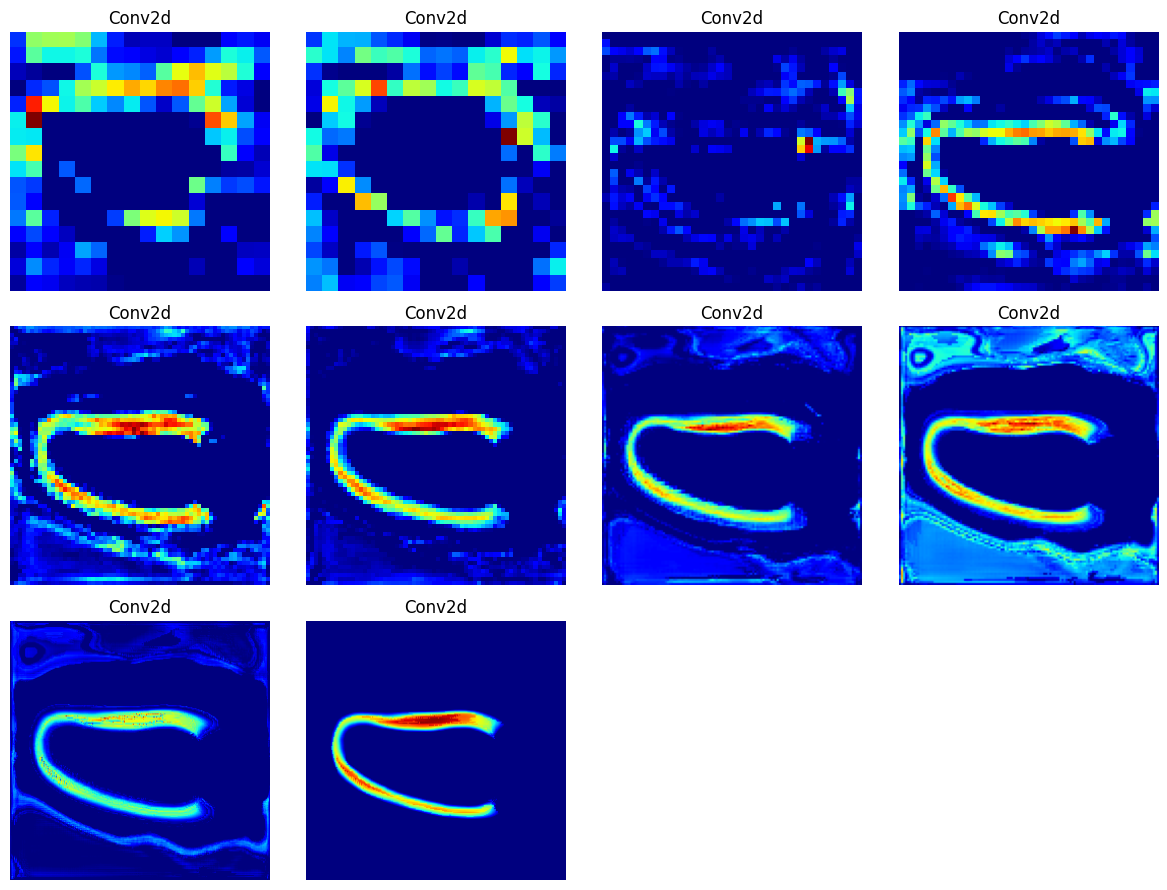

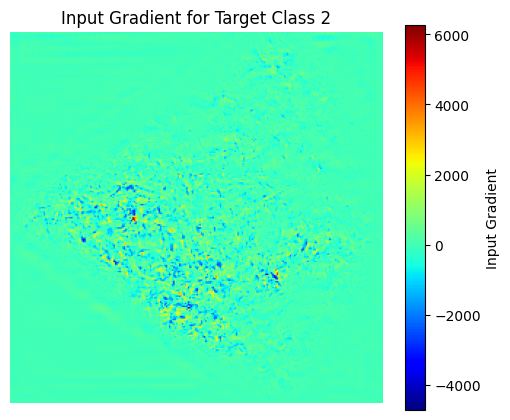

In [8]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import cv2  # For image resizing
import segmentation_models_pytorch as smp

# ----------------------------
# Helper Function to Load .nii.gz Image
# ----------------------------
def load_nii_image(image_path, target_size=(256, 256)):
    """
    Loads a 2D .nii.gz image, normalizes it, resizes it,
    and converts it to a torch tensor of shape [1, 1, H, W].
    """
    nii = nib.load(image_path)
    img_data = nii.get_fdata()
    
    # If the image is 3D, handle singleton dimensions or choose the middle slice.
    if img_data.ndim == 3:
        if img_data.shape[2] == 1:
            img_data = np.squeeze(img_data, axis=2)
        else:
            slice_index = img_data.shape[2] // 2
            img_data = img_data[:, :, slice_index]
    
    # Normalize to [0, 1]
    img_min, img_max = img_data.min(), img_data.max()
    if img_max - img_min > 0:
        img_data = (img_data - img_min) / (img_max - img_min)
    else:
        img_data = img_data - img_min
        
    # Resize using cv2 (target_size provided as (width, height))
    new_W, new_H = target_size
    resized = cv2.resize(img_data.astype(np.float32), (new_W, new_H))
    
    # Add channel dimension for a single-channel image: [1, H, W]
    resized = np.expand_dims(resized, axis=0)
    # Add batch dimension: [1, 1, H, W]
    resized = np.expand_dims(resized, axis=0)
    
    return torch.tensor(resized, dtype=torch.float32)

# ----------------------------
# Hook Functions to Capture Activations and Gradients
# ----------------------------
decoder_activations = {}
decoder_gradients = {}

def forward_hook(module, input, output):
    decoder_activations[module] = output.detach()

def backward_hook(module, grad_input, grad_output):
    # Use the first element of grad_output.
    decoder_gradients[module] = grad_output[0].detach()

def register_decoder_hooks(decoder):
    # Register hooks on all Conv2d layers within the decoder.
    for name, module in decoder.named_modules():
        if isinstance(module, nn.Conv2d):
            module.register_forward_hook(forward_hook)
            module.register_backward_hook(backward_hook)

# ----------------------------
# Main Function
# ----------------------------
def main():
    # 1. Setup & Model Loading
    model_path = r"E:\PROJECTS\Mini_Project\sem_6\Combined\denseNet.pth"
    image_path = r"E:\PROJECTS\Mini_Project\sem_6\nii_img\patient0001_2CH_ED.nii.gz"
    
    # Define UNet Model with EfficientNet-B3 Encoder.
    # Note: Here, classes=4 where channel 0 is background and channels 1-3 are targets.
    model = smp.Unet(
        encoder_name="densenet121",
        encoder_weights="imagenet",
        in_channels=1,
        classes=4,
        activation=None  # No activation; loss function applies sigmoid if needed.
    )
    
    model.load_state_dict(torch.load(model_path, map_location=torch.device("cpu")))
    model.eval()
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    # Register hooks only for layers within the decoder.
    register_decoder_hooks(model.decoder)
    
    # Load image (shape: [1, 1, H, W]) and set requires_grad.
    image = load_nii_image(image_path, target_size=(256, 256)).to(device)
    image.requires_grad = True
    
    # ---- Forward Pass ----
    encoder_features = model.encoder(image)
    decoder_output = model.decoder(*encoder_features)
    output = model.segmentation_head(decoder_output)  # Final output: [1, 4, H, W]
    segmentation_output = torch.sigmoid(output)
    
    print("Segmentation output stats:",
          "min =", segmentation_output.min().item(),
          "max =", segmentation_output.max().item(),
          "mean =", segmentation_output.mean().item())
    
    # (Optional) Visualize the original image.
    orig_img_np = image[0, 0].detach().cpu().numpy()  # [H, W]
    orig_img_np = np.stack([orig_img_np]*3, axis=-1)
    orig_img_np = np.clip(orig_img_np, 0, 1)
    plt.figure()
    plt.imshow(orig_img_np)
    plt.title("Original Image")
    plt.axis("off")
    plt.show()
    
    # 2. Compute Backward Pass to Populate Gradients in Decoder Layers
    # Choose a target class (e.g., channel 1, a foreground class) for which to compute relevance.
    target_class = 2
    loss = output[0, target_class].sum()
    model.zero_grad()
    loss.backward(retain_graph=True)
    
    # 3. Compute Relevance Maps for Each Conv2d Layer in the Decoder
    # Use a simple rule: relevance = activation * gradient.
    # Then average over channels, clamp negatives to zero, and normalize.
    decoder_relevance = {}
    for module, activation in decoder_activations.items():
        if module not in decoder_gradients:
            continue
        grad = decoder_gradients[module]
        relevance = activation * grad  # Elementwise product.
        # Average over the channel dimension (assumed to be dim=1).
        relevance_map = relevance.mean(dim=1, keepdim=True)
        # Remove negative values.
        relevance_map = torch.clamp(relevance_map, min=0)
        # Normalize the relevance map to [0, 1] for visualization.
        r_min = relevance_map.min()
        r_max = relevance_map.max()
        if r_max > r_min:
            relevance_map = (relevance_map - r_min) / (r_max - r_min)
        else:
            relevance_map = torch.zeros_like(relevance_map)
        # Squeeze batch and channel dimensions to get a 2D array.
        r_np = relevance_map.cpu().numpy().squeeze()
        if r_np.ndim != 2:
            continue
        decoder_relevance[module] = r_np
    
    # 4. Visualize All Decoder Relevance Heatmaps
    num_maps = len(decoder_relevance)
    if num_maps == 0:
        print("No decoder relevance maps found.")
        return
    grid_cols = int(np.ceil(np.sqrt(num_maps)))
    grid_rows = int(np.ceil(num_maps / grid_cols))
    
    plt.figure(figsize=(grid_cols * 3, grid_rows * 3))
    for i, (module, r_map) in enumerate(decoder_relevance.items()):
        plt.subplot(grid_rows, grid_cols, i+1)
        plt.imshow(r_map, cmap='jet')
        plt.title(module.__class__.__name__)
        plt.axis("off")
    plt.tight_layout()
    plt.show()
    
    # (Optional) Visualize the input gradient.
    grad_input = image.grad.data[0, 0].cpu().numpy()
    plt.figure(figsize=(6, 5))
    plt.imshow(grad_input, cmap='jet')
    plt.colorbar(label="Input Gradient")
    plt.title(f"Input Gradient for Target Class {target_class}")
    plt.axis("off")
    plt.show()

if __name__ == "__main__":
    main()


C:\Users\rohit\AppData\Local\Temp\ipykernel_16392\1198152186.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(model_path, map_location="cpu")


Missing keys: []
Unexpected keys: []
Seg stats: 5.700348637560637e-09 0.9999995231628418 0.2501225471496582

=== LRP Rule: LRP-0 ===
  raw relevance: -12566.806640625 15959.748046875 -2.3865489959716797


C:\Users\rohit\AppData\Local\Temp\ipykernel_16392\1198152186.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm_map = cm.get_cmap(cmap)


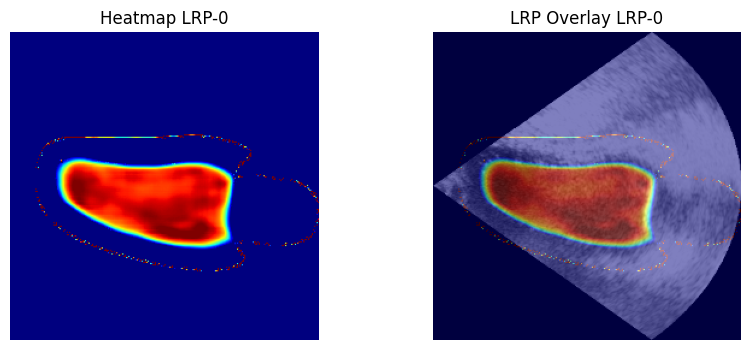


=== LRP Rule: epsilon ===
  raw relevance: -12566.806640625 15959.75 -2.3865580558776855


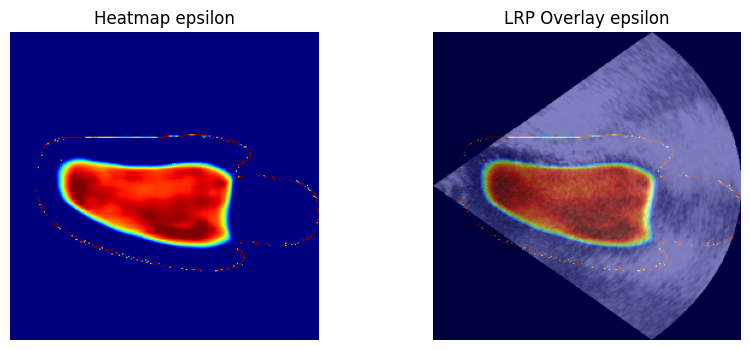


=== LRP Rule: z-plus ===
  raw relevance: 0.0 20420.42578125 1.5093823671340942


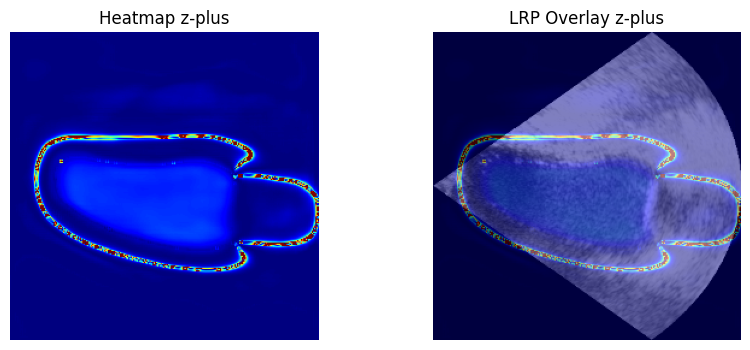


=== LRP Rule: gamma ===
  raw relevance: 0.0 2055.8193359375 0.5271390676498413


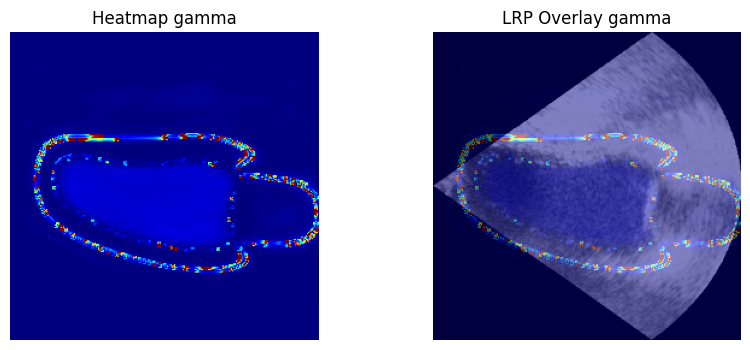


=== LRP Rule: alpha-beta ===
  raw relevance: 0.0 50552752.0 20364628.0


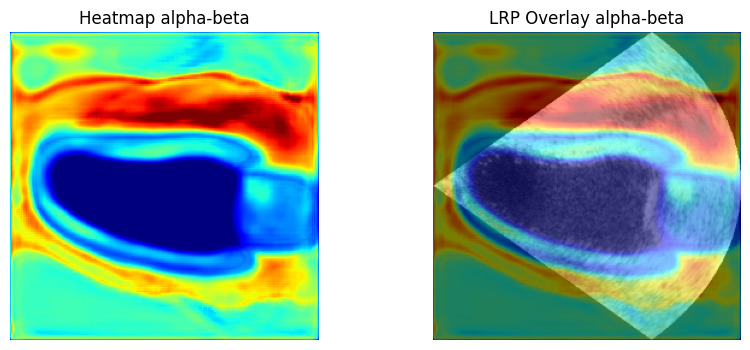


=== LRP Rule: flat ===
  raw relevance: -0.5944737195968628 -0.5944737195968628 -0.5944737792015076


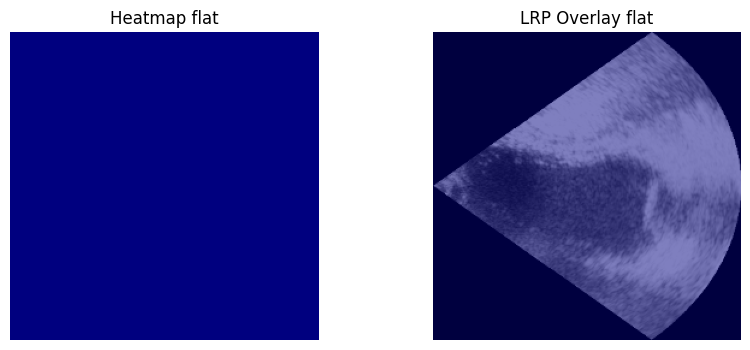


=== LRP Rule: w-squared ===
  raw relevance: -5.816317081451416 11.064033508300781 5.998712539672852


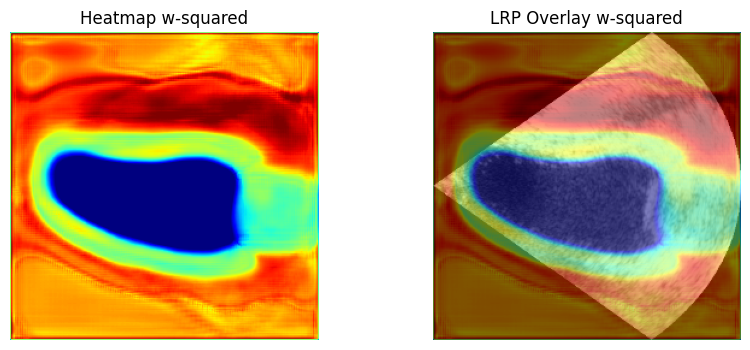


=== LRP Rule: zB ===
  raw relevance: -12566.806640625 15959.748046875 -2.3865489959716797


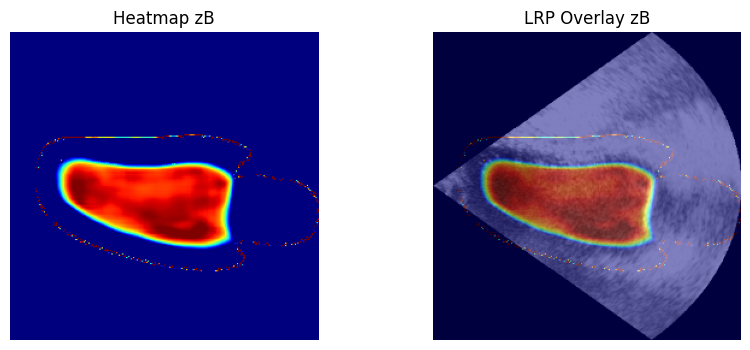

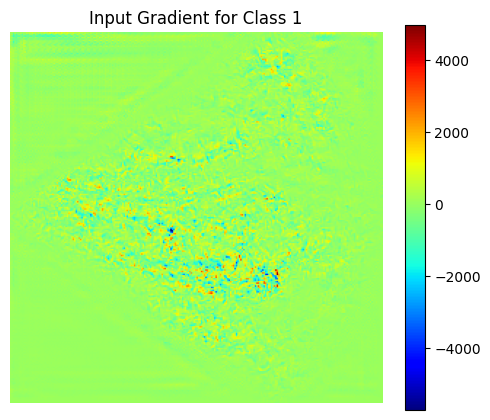

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import cv2
import segmentation_models_pytorch as smp
import matplotlib.cm as cm

# ----------------------------
# Helper Function to Load .nii.gz Image
# ----------------------------
def load_nii_image(image_path, target_size=(256, 256)):
    """
    Loads a 2D .nii.gz image, normalizes it, resizes it,
    and converts it to a torch tensor of shape [1, 1, H, W].
    """
    nii = nib.load(image_path)
    img_data = nii.get_fdata()
    
    # If 3D, take middle slice (or squeeze if singleton)
    if img_data.ndim == 3:
        if img_data.shape[2] == 1:
            img_data = np.squeeze(img_data, axis=2)
        else:
            slice_idx = img_data.shape[2] // 2
            img_data = img_data[:, :, slice_idx]
    
    # Normalize to [0, 1]
    mn, mx = img_data.min(), img_data.max()
    img = (img_data - mn) / (mx - mn) if mx > mn else img_data - mn
    
    # Resize (cv2 expects (width, height))
    img = cv2.resize(img.astype(np.float32), target_size)
    
    # Add channel and batch dims: [1,1,H,W]
    img = img[None, None, ...]
    return torch.tensor(img, dtype=torch.float32)

# ----------------------------
# Helper Functions for Heatmap Upsampling & Overlay
# ----------------------------
def resize_heatmap(hm: np.ndarray, target_size: tuple) -> np.ndarray:
    """
    Resize a single-channel heatmap to target_size using bilinear interpolation.
    """
    return cv2.resize(hm.astype(np.float32), (target_size[1], target_size[0]), interpolation=cv2.INTER_LINEAR)

def overlay_heatmap_on_image(image_np: np.ndarray, heatmap_np: np.ndarray, alpha=0.5, cmap='jet') -> np.ndarray:
    """
    Blend a heatmap onto an RGB image.
    
    image_np: HxWx3 RGB in [0,1]
    heatmap_np: HxW single-channel in [0,1]
    returns HxWx3 blended.
    """
    cm_map = cm.get_cmap(cmap)
    colored = cm_map(heatmap_np)[:, :, :3]  # HxWx3
    blended = (1 - alpha) * image_np + alpha * colored
    return np.clip(blended, 0, 1)

# ----------------------------
# Main Function
# ----------------------------
def main():
    model_path = r"E:\PROJECTS\Mini_Project\sem_6\Combined\denseNet.pth"
    image_path = r"E:\PROJECTS\Mini_Project\sem_6\nii_img\patient0001_2CH_ED.nii.gz"

    # 1. Build U-Net with DenseNet121 encoder, 4 output classes
    model = smp.Unet(
        encoder_name="densenet121",
        encoder_weights="imagenet",
        in_channels=1,
        classes=4,         # background + 3 foreground
        activation=None
    )

    # 2. Load checkpoint (raw or wrapped), strict=False to allow mismatches
    ckpt = torch.load(model_path, map_location="cpu")
    sd = ckpt.get("state_dict", ckpt)
    res = model.load_state_dict(sd, strict=False)
    print("Missing keys:", res.missing_keys)
    print("Unexpected keys:", res.unexpected_keys)

    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # 3. Load and prepare image
    image = load_nii_image(image_path, target_size=(256, 256)).to(device)
    image.requires_grad_()

    # ---- Forward Pass Split ----
    feats = model.encoder(image)
    dec_out = model.decoder(*feats)
    output = model.segmentation_head(dec_out)  # [1,4,H,W]
    seg_out = torch.sigmoid(output)
    print("Seg stats:", seg_out.min().item(), seg_out.max().item(), seg_out.mean().item())

    # Prepare original image for overlay
    orig = image[0,0].cpu().detach().numpy()
    orig_rgb = np.stack([orig]*3, axis=-1)

    # 4. Create segmentation mask with lower threshold
    mask = (seg_out.mean(1, keepdim=True) > 0.1).float()

    # 5. LRP on final conv
    final_conv = model.segmentation_head[0]
    class_idx = 1  # choose channel: 0=background, 1-3=foreground

    for rule, fn in lrp_functions.items():
        print(f"\n=== LRP Rule: {rule} ===")
        R = output.detach().clone()
        R = lrp_class_specific(R, class_idx)

        if rule == "flat":
            R = fn(final_conv, dec_out, R, seg_mask=mask)
        else:
            R = fn(final_conv, dec_out, R)

        if R.shape[1] > 1:
            R = R.mean(1, keepdim=True)

        # Optional: print raw relevance stats
        raw = R.detach()
        print("  raw relevance:", raw.min().item(), raw.max().item(), raw.mean().item())

        # Mask relevance
        R = apply_segmentation_mask(raw, mask, threshold=0.1)

        # Prepare heatmap
        hm = R.squeeze().detach().cpu().numpy()
        p99 = np.percentile(hm, 99)
        hm_clipped = np.clip(hm, 0, p99)
        hm_norm = (hm_clipped - hm_clipped.min()) / (hm_clipped.max() - hm_clipped.min() + 1e-8)

        # Upsample to input size
        hm_resized = resize_heatmap(hm_norm, target_size=orig_rgb.shape[:2])

        # Overlay
        overlay = overlay_heatmap_on_image(orig_rgb, hm_resized, alpha=0.5, cmap='jet')

        # Display
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1)
        plt.imshow(hm_resized, cmap='jet')
        plt.title(f"Heatmap {rule}")
        plt.axis('off')

        plt.subplot(1,2,2)
        plt.imshow(overlay)
        plt.title(f"LRP Overlay {rule}")
        plt.axis('off')
        plt.show()

    # 6. Input gradient visualization
    model.zero_grad()
    output[0, class_idx].sum().backward(retain_graph=True)
    grad = image.grad[0,0].detach().cpu().numpy()

    plt.figure(figsize=(6,5))
    plt.imshow(grad, cmap='jet')
    plt.colorbar()
    plt.title(f"Input Gradient for Class {class_idx}")
    plt.axis('off')
    plt.show()

if __name__ == "__main__":
    main()


C:\Users\rohit\AppData\Local\Temp\ipykernel_16392\1443802682.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(model_path, map_location="cpu")


Missing keys: []
Unexpected keys: []
Seg stats: 5.700348637560637e-09 0.9999995231628418 0.2501225471496582

=== LRP Rule: LRP-0 ===
  raw relevance: -254.70230102539062 207.6446533203125 -2.1522889137268066


C:\Users\rohit\AppData\Local\Temp\ipykernel_16392\1443802682.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm_map = cm.get_cmap(cmap)


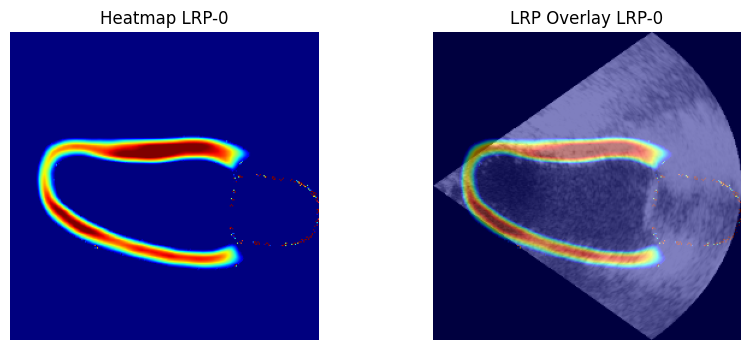


=== LRP Rule: epsilon ===
  raw relevance: -253.7409210205078 206.83285522460938 -2.152292251586914


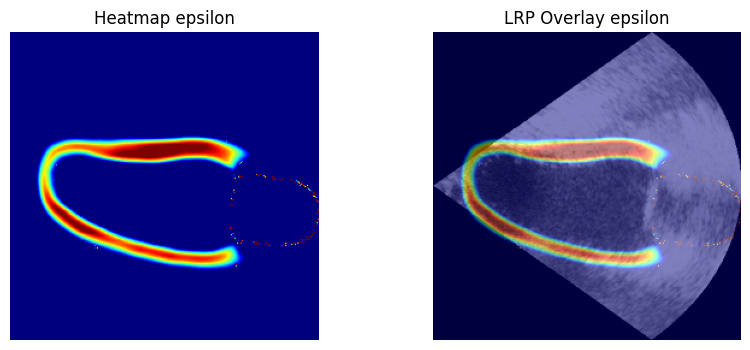


=== LRP Rule: z-plus ===
  raw relevance: 0.0 102.71575164794922 0.10796889662742615


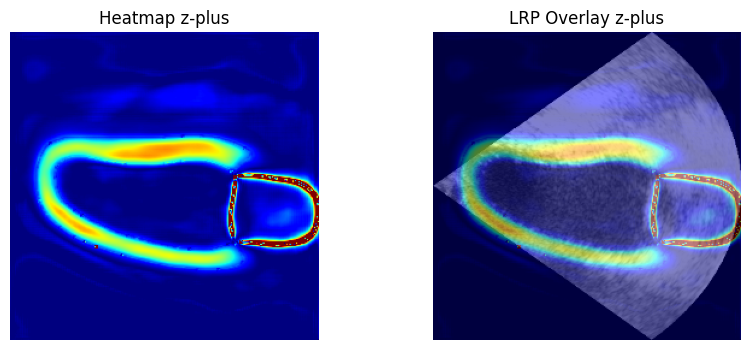


=== LRP Rule: gamma ===
  raw relevance: 0.0 215.55026245117188 0.14196965098381042


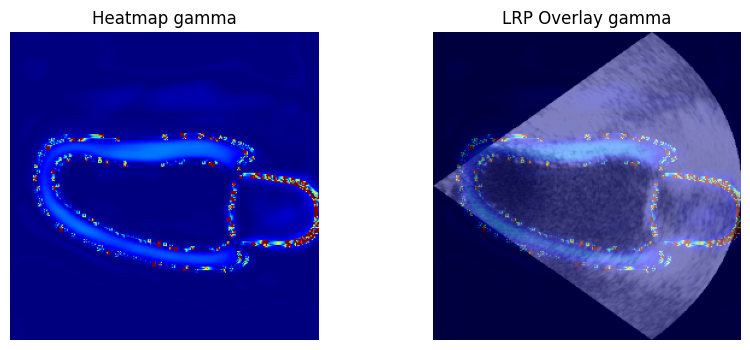


=== LRP Rule: alpha-beta ===
  raw relevance: 0.0 40675660.0 17766176.0


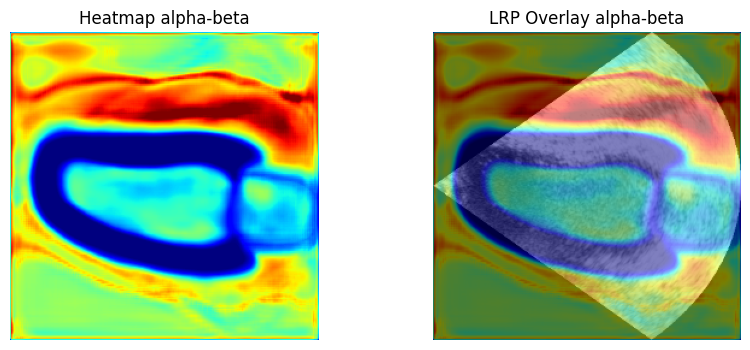


=== LRP Rule: flat ===
  raw relevance: -0.5408902764320374 -0.5408902764320374 -0.5408902764320374


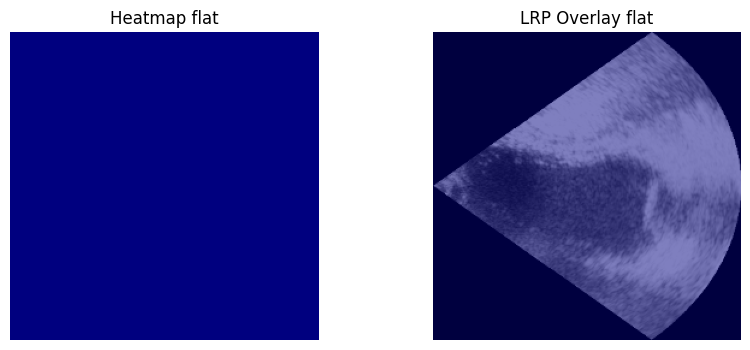


=== LRP Rule: w-squared ===
  raw relevance: -5.983715534210205 11.00941276550293 5.518373012542725


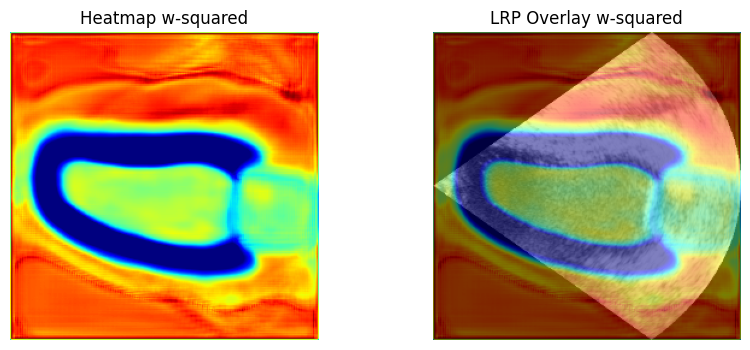


=== LRP Rule: zB ===
  raw relevance: -254.70230102539062 207.6446533203125 -2.1522889137268066


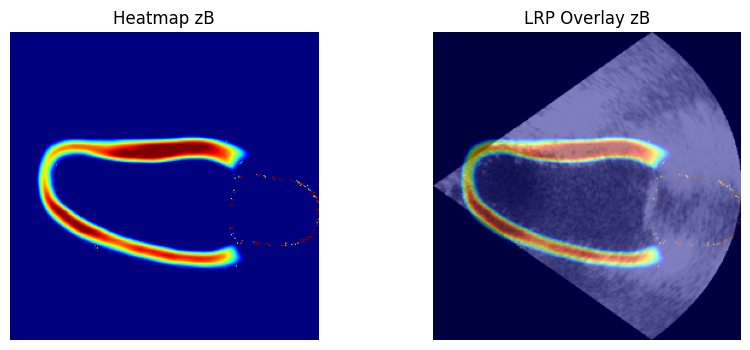

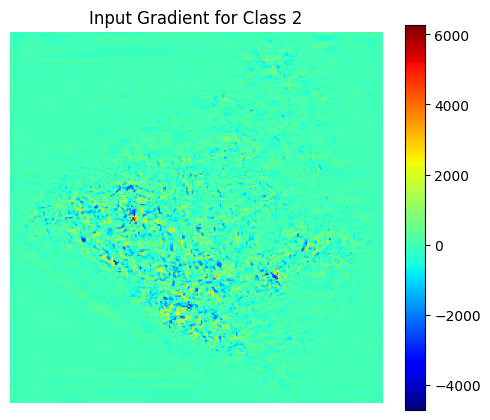

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import cv2
import segmentation_models_pytorch as smp
import matplotlib.cm as cm

# ----------------------------
# Helper Function to Load .nii.gz Image
# ----------------------------
def load_nii_image(image_path, target_size=(256, 256)):
    """
    Loads a 2D .nii.gz image, normalizes it, resizes it,
    and converts it to a torch tensor of shape [1, 1, H, W].
    """
    nii = nib.load(image_path)
    img_data = nii.get_fdata()
    
    # If 3D, take middle slice (or squeeze if singleton)
    if img_data.ndim == 3:
        if img_data.shape[2] == 1:
            img_data = np.squeeze(img_data, axis=2)
        else:
            slice_idx = img_data.shape[2] // 2
            img_data = img_data[:, :, slice_idx]
    
    # Normalize to [0, 1]
    mn, mx = img_data.min(), img_data.max()
    img = (img_data - mn) / (mx - mn) if mx > mn else img_data - mn
    
    # Resize (cv2 expects (width, height))
    img = cv2.resize(img.astype(np.float32), target_size)
    
    # Add channel and batch dims: [1,1,H,W]
    img = img[None, None, ...]
    return torch.tensor(img, dtype=torch.float32)

# ----------------------------
# Helper Functions for Heatmap Upsampling & Overlay
# ----------------------------
def resize_heatmap(hm: np.ndarray, target_size: tuple) -> np.ndarray:
    """
    Resize a single-channel heatmap to target_size using bilinear interpolation.
    """
    return cv2.resize(hm.astype(np.float32), (target_size[1], target_size[0]), interpolation=cv2.INTER_LINEAR)

def overlay_heatmap_on_image(image_np: np.ndarray, heatmap_np: np.ndarray, alpha=0.5, cmap='jet') -> np.ndarray:
    """
    Blend a heatmap onto an RGB image.
    
    image_np: HxWx3 RGB in [0,1]
    heatmap_np: HxW single-channel in [0,1]
    returns HxWx3 blended.
    """
    cm_map = cm.get_cmap(cmap)
    colored = cm_map(heatmap_np)[:, :, :3]  # HxWx3
    blended = (1 - alpha) * image_np + alpha * colored
    return np.clip(blended, 0, 1)

# ----------------------------
# Main Function
# ----------------------------
def main():
    model_path = r"E:\PROJECTS\Mini_Project\sem_6\Combined\denseNet.pth"
    image_path = r"E:\PROJECTS\Mini_Project\sem_6\nii_img\patient0001_2CH_ED.nii.gz"

    # 1. Build U-Net with DenseNet121 encoder, 4 output classes
    model = smp.Unet(
        encoder_name="densenet121",
        encoder_weights="imagenet",
        in_channels=1,
        classes=4,         # background + 3 foreground
        activation=None
    )

    # 2. Load checkpoint (raw or wrapped), strict=False to allow mismatches
    ckpt = torch.load(model_path, map_location="cpu")
    sd = ckpt.get("state_dict", ckpt)
    res = model.load_state_dict(sd, strict=False)
    print("Missing keys:", res.missing_keys)
    print("Unexpected keys:", res.unexpected_keys)

    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # 3. Load and prepare image
    image = load_nii_image(image_path, target_size=(256, 256)).to(device)
    image.requires_grad_()

    # ---- Forward Pass Split ----
    feats = model.encoder(image)
    dec_out = model.decoder(*feats)
    output = model.segmentation_head(dec_out)  # [1,4,H,W]
    seg_out = torch.sigmoid(output)
    print("Seg stats:", seg_out.min().item(), seg_out.max().item(), seg_out.mean().item())

    # Prepare original image for overlay
    orig = image[0,0].cpu().detach().numpy()
    orig_rgb = np.stack([orig]*3, axis=-1)

    # 4. Create segmentation mask with lower threshold
    mask = (seg_out.mean(1, keepdim=True) > 0.1).float()

    # 5. LRP on final conv
    final_conv = model.segmentation_head[0]
    class_idx = 2  # choose channel: 0=background, 1-3=foreground

    for rule, fn in lrp_functions.items():
        print(f"\n=== LRP Rule: {rule} ===")
        R = output.detach().clone()
        R = lrp_class_specific(R, class_idx)

        if rule == "flat":
            R = fn(final_conv, dec_out, R, seg_mask=mask)
        else:
            R = fn(final_conv, dec_out, R)

        if R.shape[1] > 1:
            R = R.mean(1, keepdim=True)

        # Optional: print raw relevance stats
        raw = R.detach()
        print("  raw relevance:", raw.min().item(), raw.max().item(), raw.mean().item())

        # Mask relevance
        R = apply_segmentation_mask(raw, mask, threshold=0.1)

        # Prepare heatmap
        hm = R.squeeze().detach().cpu().numpy()
        p99 = np.percentile(hm, 99)
        hm_clipped = np.clip(hm, 0, p99)
        hm_norm = (hm_clipped - hm_clipped.min()) / (hm_clipped.max() - hm_clipped.min() + 1e-8)

        # Upsample to input size
        hm_resized = resize_heatmap(hm_norm, target_size=orig_rgb.shape[:2])

        # Overlay
        overlay = overlay_heatmap_on_image(orig_rgb, hm_resized, alpha=0.5, cmap='jet')

        # Display
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1)
        plt.imshow(hm_resized, cmap='jet')
        plt.title(f"Heatmap {rule}")
        plt.axis('off')

        plt.subplot(1,2,2)
        plt.imshow(overlay)
        plt.title(f"LRP Overlay {rule}")
        plt.axis('off')
        plt.show()

    # 6. Input gradient visualization
    model.zero_grad()
    output[0, class_idx].sum().backward(retain_graph=True)
    grad = image.grad[0,0].detach().cpu().numpy()

    plt.figure(figsize=(6,5))
    plt.imshow(grad, cmap='jet')
    plt.colorbar()
    plt.title(f"Input Gradient for Class {class_idx}")
    plt.axis('off')
    plt.show()

if __name__ == "__main__":
    main()

C:\Users\rohit\AppData\Local\Temp\ipykernel_16392\1433651878.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(model_path, map_location="cpu")


Missing keys: []
Unexpected keys: []
Seg stats: 5.700348637560637e-09 0.9999995231628418 0.2501225471496582

=== LRP Rule: LRP-0 ===
  raw relevance: -11437.6162109375 14525.5712890625 -2.5346765518188477


C:\Users\rohit\AppData\Local\Temp\ipykernel_16392\1433651878.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm_map = cm.get_cmap(cmap)


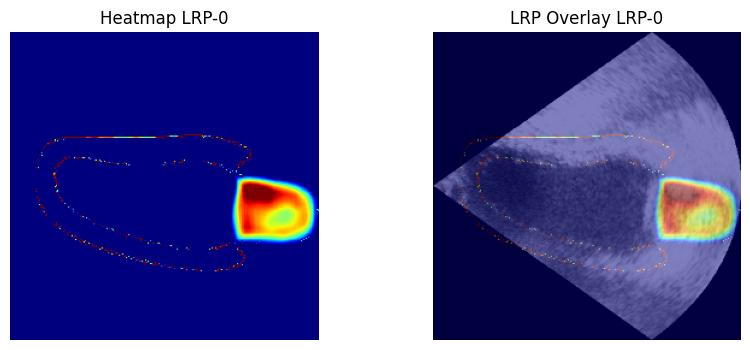


=== LRP Rule: epsilon ===
  raw relevance: -11437.6162109375 14525.5732421875 -2.534681797027588


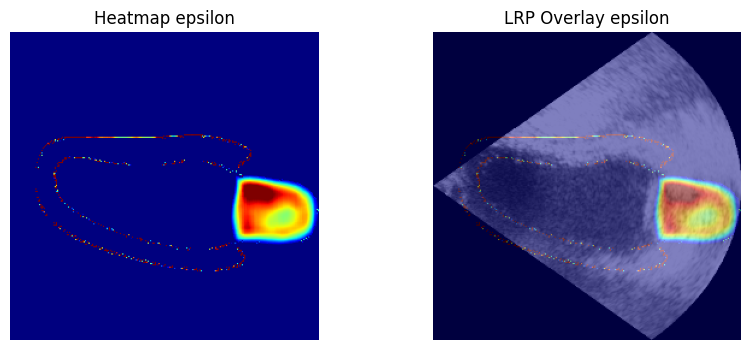


=== LRP Rule: z-plus ===
  raw relevance: 0.0 18585.482421875 1.4072624444961548


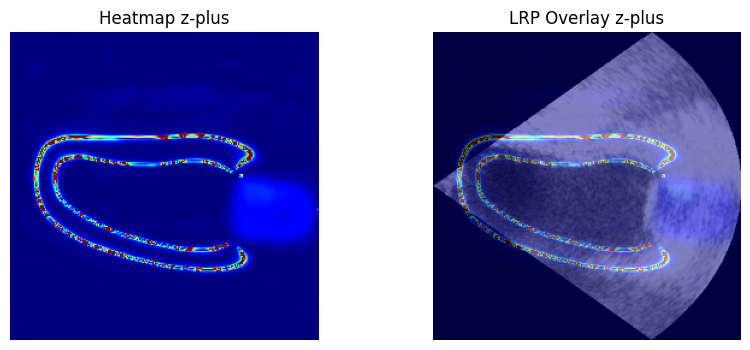


=== LRP Rule: gamma ===
  raw relevance: 0.0 1835.725341796875 0.5103127360343933


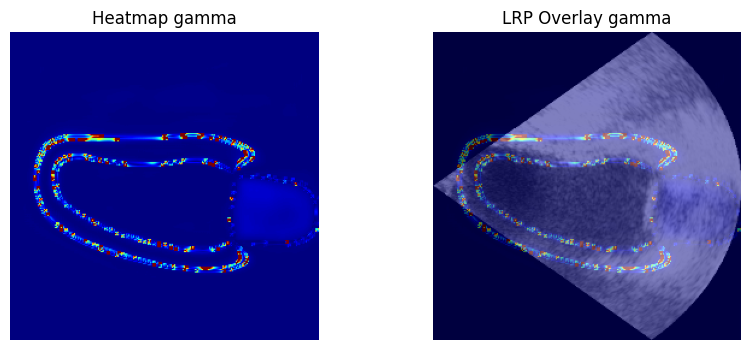


=== LRP Rule: alpha-beta ===
  raw relevance: 0.0 43014344.0 19646050.0


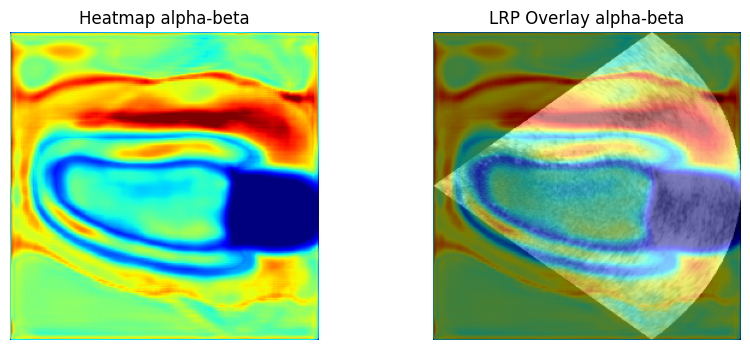


=== LRP Rule: flat ===
  raw relevance: -0.6312845945358276 -0.6312845945358276 -0.6312846541404724


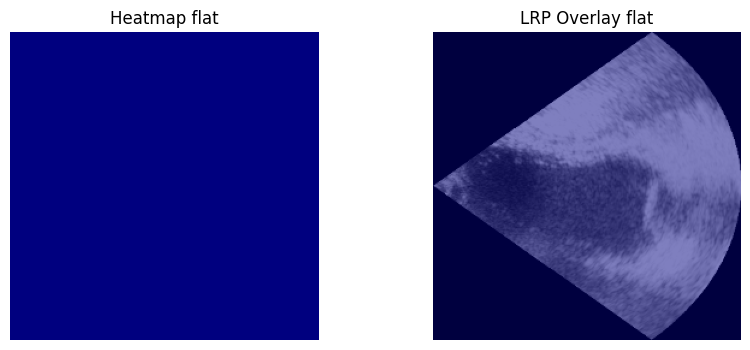


=== LRP Rule: w-squared ===
  raw relevance: -4.255889415740967 10.357216835021973 6.449637413024902


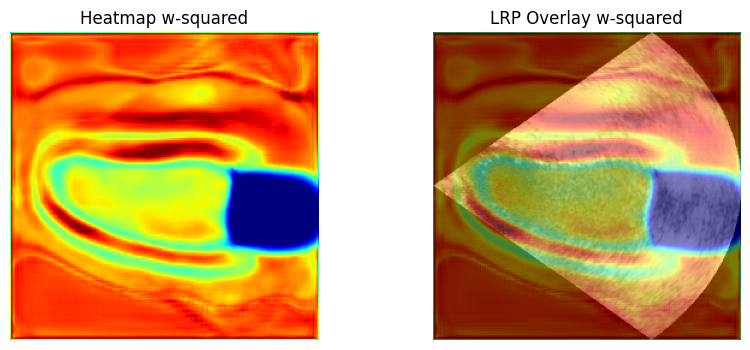


=== LRP Rule: zB ===
  raw relevance: -11437.6162109375 14525.5712890625 -2.5346765518188477


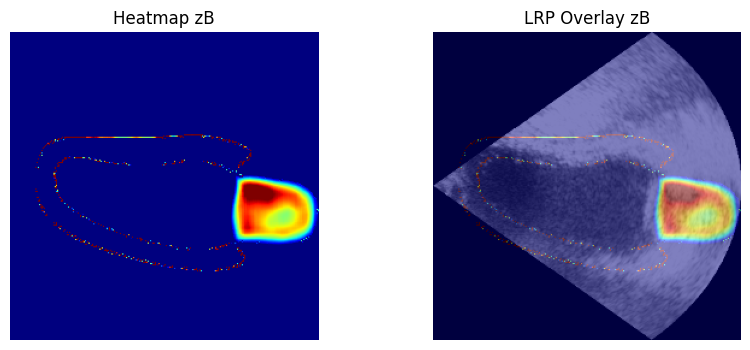

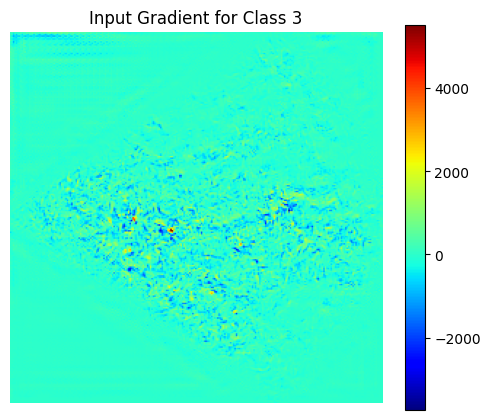

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import cv2
import segmentation_models_pytorch as smp
import matplotlib.cm as cm

# ----------------------------
# Helper Function to Load .nii.gz Image
# ----------------------------
def load_nii_image(image_path, target_size=(256, 256)):
    """
    Loads a 2D .nii.gz image, normalizes it, resizes it,
    and converts it to a torch tensor of shape [1, 1, H, W].
    """
    nii = nib.load(image_path)
    img_data = nii.get_fdata()
    
    # If 3D, take middle slice (or squeeze if singleton)
    if img_data.ndim == 3:
        if img_data.shape[2] == 1:
            img_data = np.squeeze(img_data, axis=2)
        else:
            slice_idx = img_data.shape[2] // 2
            img_data = img_data[:, :, slice_idx]
    
    # Normalize to [0, 1]
    mn, mx = img_data.min(), img_data.max()
    img = (img_data - mn) / (mx - mn) if mx > mn else img_data - mn
    
    # Resize (cv2 expects (width, height))
    img = cv2.resize(img.astype(np.float32), target_size)
    
    # Add channel and batch dims: [1,1,H,W]
    img = img[None, None, ...]
    return torch.tensor(img, dtype=torch.float32)

# ----------------------------
# Helper Functions for Heatmap Upsampling & Overlay
# ----------------------------
def resize_heatmap(hm: np.ndarray, target_size: tuple) -> np.ndarray:
    """
    Resize a single-channel heatmap to target_size using bilinear interpolation.
    """
    return cv2.resize(hm.astype(np.float32), (target_size[1], target_size[0]), interpolation=cv2.INTER_LINEAR)

def overlay_heatmap_on_image(image_np: np.ndarray, heatmap_np: np.ndarray, alpha=0.5, cmap='jet') -> np.ndarray:
    """
    Blend a heatmap onto an RGB image.
    
    image_np: HxWx3 RGB in [0,1]
    heatmap_np: HxW single-channel in [0,1]
    returns HxWx3 blended.
    """
    cm_map = cm.get_cmap(cmap)
    colored = cm_map(heatmap_np)[:, :, :3]  # HxWx3
    blended = (1 - alpha) * image_np + alpha * colored
    return np.clip(blended, 0, 1)

# ----------------------------
# Main Function
# ----------------------------
def main():
    model_path = r"E:\PROJECTS\Mini_Project\sem_6\Combined\denseNet.pth"
    image_path = r"E:\PROJECTS\Mini_Project\sem_6\nii_img\patient0001_2CH_ED.nii.gz"

    # 1. Build U-Net with DenseNet121 encoder, 4 output classes
    model = smp.Unet(
        encoder_name="densenet121",
        encoder_weights="imagenet",
        in_channels=1,
        classes=4,         # background + 3 foreground
        activation=None
    )

    # 2. Load checkpoint (raw or wrapped), strict=False to allow mismatches
    ckpt = torch.load(model_path, map_location="cpu")
    sd = ckpt.get("state_dict", ckpt)
    res = model.load_state_dict(sd, strict=False)
    print("Missing keys:", res.missing_keys)
    print("Unexpected keys:", res.unexpected_keys)

    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # 3. Load and prepare image
    image = load_nii_image(image_path, target_size=(256, 256)).to(device)
    image.requires_grad_()

    # ---- Forward Pass Split ----
    feats = model.encoder(image)
    dec_out = model.decoder(*feats)
    output = model.segmentation_head(dec_out)  # [1,4,H,W]
    seg_out = torch.sigmoid(output)
    print("Seg stats:", seg_out.min().item(), seg_out.max().item(), seg_out.mean().item())

    # Prepare original image for overlay
    orig = image[0,0].cpu().detach().numpy()
    orig_rgb = np.stack([orig]*3, axis=-1)

    # 4. Create segmentation mask with lower threshold
    mask = (seg_out.mean(1, keepdim=True) > 0.1).float()

    # 5. LRP on final conv
    final_conv = model.segmentation_head[0]
    class_idx = 3  # choose channel: 0=background, 1-3=foreground

    for rule, fn in lrp_functions.items():
        print(f"\n=== LRP Rule: {rule} ===")
        R = output.detach().clone()
        R = lrp_class_specific(R, class_idx)

        if rule == "flat":
            R = fn(final_conv, dec_out, R, seg_mask=mask)
        else:
            R = fn(final_conv, dec_out, R)

        if R.shape[1] > 1:
            R = R.mean(1, keepdim=True)

        # Optional: print raw relevance stats
        raw = R.detach()
        print("  raw relevance:", raw.min().item(), raw.max().item(), raw.mean().item())

        # Mask relevance
        R = apply_segmentation_mask(raw, mask, threshold=0.1)

        # Prepare heatmap
        hm = R.squeeze().detach().cpu().numpy()
        p99 = np.percentile(hm, 99)
        hm_clipped = np.clip(hm, 0, p99)
        hm_norm = (hm_clipped - hm_clipped.min()) / (hm_clipped.max() - hm_clipped.min() + 1e-8)

        # Upsample to input size
        hm_resized = resize_heatmap(hm_norm, target_size=orig_rgb.shape[:2])

        # Overlay
        overlay = overlay_heatmap_on_image(orig_rgb, hm_resized, alpha=0.5, cmap='jet')

        # Display
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1)
        plt.imshow(hm_resized, cmap='jet')
        plt.title(f"Heatmap {rule}")
        plt.axis('off')

        plt.subplot(1,2,2)
        plt.imshow(overlay)
        plt.title(f"LRP Overlay {rule}")
        plt.axis('off')
        plt.show()

    # 6. Input gradient visualization
    model.zero_grad()
    output[0, class_idx].sum().backward(retain_graph=True)
    grad = image.grad[0,0].detach().cpu().numpy()

    plt.figure(figsize=(6,5))
    plt.imshow(grad, cmap='jet')
    plt.colorbar()
    plt.title(f"Input Gradient for Class {class_idx}")
    plt.axis('off')
    plt.show()

if __name__ == "__main__":
    main()